# Background
Scientists define there to be two main types of age: chronological, and biological age. Chronological age is based on how long you have been alive (years since birth), whereas biological age is a rough estimate of how healthy your body is by measuring various different biomarkers. For more information on this, check out my recent article on biological age right here: [What is Biological Age?](https://medium.com/biotein/what-is-biological-age-383692f53e60)

One way of determining biological age (as also described in the article) is to measure the methylation levels in your genome. At sites known as CpG sites, along your DNA, various proteins can add on or remove methyl groups, in order to control which genes are expressed into proteins, and which ones aren't. As you age, however, the systems responsible for maintaining this control of the genome begin to break down, leading to errors in methylation. As such, some sites begin to see an accumulation of methyl tags, while others have their tags removed, as you age.

Dr. Steve Horvath, longevity researcher at University of California Los Angeles, used this progression to develop a system known as the Horvath aging clock, which is able to produce an accurate estimate of your biological age. For example, after analyzing the methylation levels in a sample of your cells, the clock might tell you that your biological age is around 30, which basically means that your methylation levels (and your body's health) is similar to the average 30-year-old. If your actual age is somewhere around 40, this means you are living a healthy life, whereas if you are only 20 years old, then this suggests that you are living an unhealthy life. This information thus equips people with the knowledge to take control of their lifestyle and live a healthy life.

# Brief Explanation of This Project
In this project, I aim to somewhat replicate the epigenetic clock developed by Horvath, using methylation data taken from blood samples to predict an individual's age. The datasets and methylation sites chosen for this project were advised by the research paper titled [Human Age Prediction Based on DNA Methylation Using a Gradient Boosting Regressor](https://doi.org/10.3390/genes9090424).
There are two notable differences between the paper and this code:
1. Since this code also takes into account the gender of the patients whose methylation data is available, GSE30870, which does not contain gender information in the dataset, was removed from the sample.
2. This notebook contains three different ML Regression algorithms and a Deep Neural Network, and compares the performance of each model on the training and testing dataset. The four models developed in this notebook are: Multivariable Linear Regression, Random Forest Regression, Gradient Boosting Regression, and a Deep Neural Network.

In [1]:
# Imports
import pandas as pd

from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import numpy as np

# Preparing the Data

In [2]:
# Loading methylation dataset using Pandas
path = "./Healthy_Methylation_Dataset.csv"
healthy_df = pd.read_csv(path)
healthy_df.head()

,...1,cg09809672,cg22736354,cg02228185,cg01820374,cg06493994,cg19761273,gender,age
0,GSM507152,0.392464,0.281630,0.352591,0.315924,0.111604,0.211683,1,71.06
1,GSM507153,0.377919,0.238900,0.520396,0.323641,0.127965,0.184307,1,69.65
2,GSM507154,0.458522,0.204078,0.519273,0.363714,0.119891,0.215067,1,65.79
3,GSM507155,0.479108,0.154893,0.618859,0.493972,0.088941,0.240057,1,49.39
4,GSM507156,0.418763,0.217832,0.561005,0.398580,0.085992,0.207462,1,60.68


In [3]:
healthy_df.describe()

,cg09809672,cg22736354,cg02228185,cg01820374,cg06493994,cg19761273,gender,age
count,1433.000000,1433.000000,1432.000000,1433.000000,1433.000000,1433.000000,1440.000000,1342.000000
mean,0.643915,-0.034537,0.707461,0.469240,-0.126709,0.190323,0.398611,16.876972
std,0.182962,0.631238,0.181514,0.249634,0.818831,0.429598,0.489782,20.195080
min,-0.142805,-3.426375,0.249870,-0.652701,-3.671870,-1.865495,0.000000,0.000000
25%,0.508143,0.063395,0.634600,0.369900,0.038618,0.220460,0.000000,0.000000
50%,0.649500,0.093690,0.716848,0.500220,0.056750,0.295079,0.000000,9.250000
75%,0.819000,0.192362,0.791519,0.610516,0.112080,0.369000,1.000000,26.000000
max,0.981229,0.460100,1.836750,0.946000,0.308694,0.809860,1.000000,76.498290


Here we first shuffle our dataset to remove any confounding factors that may exist as a result of the ordering of the dataset, such as an inappropriate train-test split. We also reset the indices after the shuffling, and drop all rows with missing values (or NaNs).

In [4]:
# Shuffle dataframe to randomize data order, possibly preventing confounding factors
healthy_df = shuffle(healthy_df)
healthy_df.reset_index(inplace=True, drop=True)

# Remove patient ID column
healthy_df = healthy_df.drop(['...1'], axis=1)

# Drop all rows with NaN values
healthy_df = healthy_df.dropna()

healthy_df.head()

,cg09809672,cg22736354,cg02228185,cg01820374,cg06493994,cg19761273,gender,age
0,0.664730,0.232440,0.786340,0.437130,0.204710,0.385560,0,16.000000
1,0.761120,0.217750,0.877030,0.462410,0.156890,0.399700,0,4.916667
2,0.630100,0.081750,0.713800,0.532160,0.069550,0.340250,0,8.000000
3,0.305637,0.246124,0.412507,0.315123,0.070135,0.237811,1,72.580000
4,0.731670,0.073200,0.695460,0.489000,0.044580,0.340070,0,7.083333


In [5]:
# Checking if there are any remaining NaNs in the dataset
np.where(pd.isnull(healthy_df))

(array([], dtype=int64), array([], dtype=int64))

Below, we plot the correlation matrix, or heatmap, to compare the variables. As can be seen in the lowest row (labelled age),  the methylation sites that might be the best predictors of age (the most strongly correlated, whether negative or positive) are cg09809672, cg01820374, and cg19761273.
We also see that gender seems to have a positive positive correlation with age. This suggests a possible confounding factor that may arise as a result of the dataset, since it seems that the females in the dataset (labelled as 1) are older than the males (labelled 0).

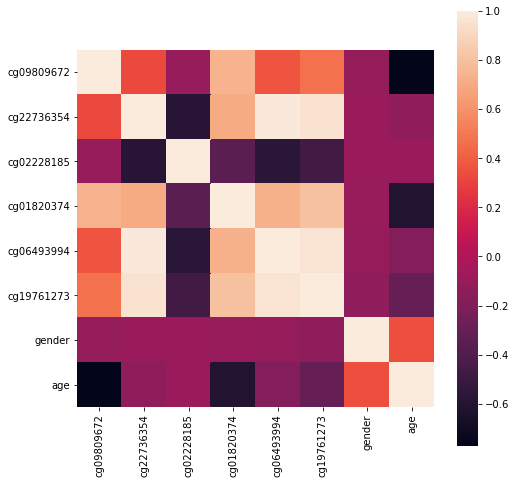

In [6]:
# Plot correlation matrix, or heatmap, to compare variables. As can 
# be seen in the lowest row (labelled age), the methylation sites
# that might act as the best predictors of age are cg09809672,
# cg01820374, and cg19761273.
import seaborn as sb
C_mat = healthy_df.corr()
fig = plt.figure(figsize = (8,8))

sb.heatmap(C_mat, vmax=1, square=True)
plt.show()

In [7]:
# Normalizing the methylation and gender data with a Standard Scaler.
X = healthy_df[['cg09809672', 'cg22736354', 'cg02228185', 'cg01820374', 'cg06493994', 'cg19761273', 'gender']]
std_scaler = StandardScaler()
std_scaler

# Separating X vs. y dataframes
X_std = pd.DataFrame(std_scaler.fit_transform(X), columns=X.columns)
y = healthy_df['age']

In [8]:
# Separating dataset into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

# Training the Models

## Linear Regression Model

Based on the score and predictions printed below, we see that the linear regression model is only somewhate capable of accurately predicting the age of an individual using the methylation levels inputted, with roughly 75% testing accuracy (varies with each run).

In [9]:
# Training the multivariate linear regression model
linear_regressor = linear_model.LinearRegression()
linear_regressor.fit(X_train, y_train)

# Accuracy on the testing set
print(linear_regressor.score(X_test, y_test))

0.7688030974438016


In [10]:
predictions = linear_regressor.predict(X_test)

# Since age cannot be negative, changing all negative predictions to age 0
for n, element in enumerate(predictions):
    if element < 0:
        predictions[n] = 0

# Looking at sample predictions for the testing set
for i in range(0, 10):
    print("Prediction:", predictions[i], "\tActual:", y_test.iloc[i])

Prediction: 47.72732399894276 	Actual: 62.75428
Prediction: 48.03760347195022 	Actual: 54.551680000000005
Prediction: 54.95587535235778 	Actual: 28.0
Prediction: 8.604857980745521 	Actual: 4.166666667
Prediction: 49.17716720430526 	Actual: 44.0
Prediction: 0.0005453884303250334 	Actual: 0.0
Prediction: 9.802658102869884 	Actual: 5.666666667
Prediction: 7.950791333972575 	Actual: 4.083333333
Prediction: 0.0 	Actual: 0.0
Prediction: 0.0 	Actual: 0.0


## Random Forest Regression Model

Looking at the score for the model below, we can see that the Random Forest Regressor model is quite accurate at predicting an individual's age using their methylation data, with roughly 92% testing accuracy (varies with each run).

In [11]:
# Building and training the Random Forest Regressor model
from sklearn.ensemble import RandomForestRegressor

# Optimal value for n_estimators was determined by trial and error, comparing the score for each trial
random_forest_regressor = RandomForestRegressor(n_estimators = 17, random_state = 0)
random_forest_regressor.fit(X_train, y_train)

# Accuracy on the testing set
print(random_forest_regressor.score(X_test, y_test))

0.9301906568388421


In [12]:
predictions = random_forest_regressor.predict(X_test)

# Since age cannot be negative, changing all negative predictions to age 0
for n, element in enumerate(predictions):
    if element < 0:
        predictions[n] = 0

# Looking at sample predictions for the testing set
for i in range(0, 10):
  print("Prediction:", predictions[i],"\tActual:", y_test.iloc[i])

Prediction: 60.441115882352946 	Actual: 62.75428
Prediction: 60.36734999999999 	Actual: 54.551680000000005
Prediction: 45.80450980411765 	Actual: 28.0
Prediction: 5.553921568705882 	Actual: 4.166666667
Prediction: 44.646971176470586 	Actual: 44.0
Prediction: 0.0 	Actual: 0.0
Prediction: 7.274509803647058 	Actual: 5.666666667
Prediction: 6.4215686271764705 	Actual: 4.083333333
Prediction: 0.0 	Actual: 0.0
Prediction: 0.181372549 	Actual: 0.0


## Gradient Boosting Regression Model

Looking at the two code blocks below, we see that the Gradient Boosting Regressor model, though not as accurate as the Random Forest Regressor, is still fairly accurate at generating the predictions using the data given, with roughly 86% accuracy on the testing set (varies with each run).

In [13]:
# Building and training the Gradient Boosting Regressor model
from sklearn.ensemble import GradientBoostingRegressor

# The values of n_estimators, max_depth, and learning_rate were determined by trial and error,
# to obtain the obtimal values shown below.
params = {'n_estimators':3, 'max_depth':3, 'learning_rate': 1, 'criterion': 'mse'}

gradient_boosting_regressor = GradientBoostingRegressor(**params)
gradient_boosting_regressor.fit(X_train, y_train)

print(gradient_boosting_regressor.score(X_test, y_test))

0.8590492603783062


In [14]:
predictions = gradient_boosting_regressor.predict(X_test)
for i in range(0, 10):
    if predictions[i] < 0:
        predictions[i] = 0
    print("Prediction:", predictions[i],"\tActual:", y_test.iloc[i])

Prediction: 64.08599554406518 	Actual: 62.75428
Prediction: 66.05897277204045 	Actual: 54.551680000000005
Prediction: 35.35789682177474 	Actual: 28.0
Prediction: 7.032895678696306 	Actual: 4.166666667
Prediction: 61.98301230349228 	Actual: 44.0
Prediction: 0.0 	Actual: 0.0
Prediction: 10.76967046925835 	Actual: 5.666666667
Prediction: 10.76967046925835 	Actual: 4.083333333
Prediction: 0.0 	Actual: 0.0
Prediction: 0.8061334187355035 	Actual: 0.0


## Regressive Neural Network

In [15]:
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

# Creating the sequential neural network model
NN_model = Sequential()

# Input layer
NN_model.add(Dense(128, kernel_initializer='normal', input_dim=X_train.shape[1], activation='relu'))

# Hidden layers
NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))

# Output layer
NN_model.add(Dense(1, kernel_initializer='normal', activation='linear'))


# Compile NN
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error', 'accuracy'])
NN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 165,889
Trainable params: 165,889
Non-trainable params: 0
_________________________________________________________________


As seen in the plots showing the accuracy and loss as the model continues training, or the evaluation in the very last block, the neural network is extremely poor at predicting an individual's age, with an accuracy of around 30% (varies with each run).

In [16]:
history = NN_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split = 0.2, verbose=0)

In [17]:
print(history.history.keys())

dict_keys(['loss', 'mean_absolute_error', 'accuracy', 'val_loss', 'val_mean_absolute_error', 'val_accuracy'])


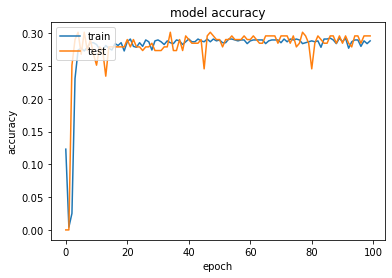

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

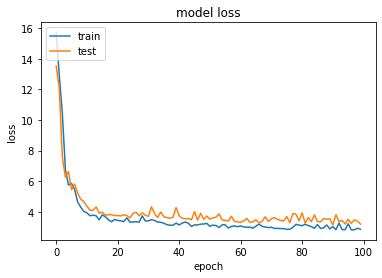

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
evaluation = NN_model.evaluate(X_test, y_test, batch_size=32)
loss = evaluation[0]
acc = evaluation[2]
print("Test loss:", loss)
print("Test accuracy:", acc)

14/14 [==============================] - 0s 1ms/step - loss: 2.9464 - mean_absolute_error: 2.9464 - accuracy: 0.3016
Test loss: 2.946436882019043
Test accuracy: 0.30158731341362


## Conclusion
With the code seen above, we conclude that the Random Forest Regression model is the best model of the four, and is able to fairly accurately predict an individual's age using their methylation levels at the 6 sites. Not far behind in accuracy is the Gradient Boosting model. The Linear Regression model is not as accurately able to predict the age, but is still able to do so much much more accurately than the neural network, which was only able to achieve a testing accuracy of roughly 30%, and validation accuracy ranging from 30-35%.

# Testing on Diseased Patients

Some of the models developed above are capable of accurately predicting the age of healthy individuals based on their methylation levels. However, if biological age is really a marker of one's health, then it should be expected that unhealthy individuals (or diseased individuals) should display methylation levels corresponding with a worse biological age. To test this, we import a small dataset (GSE20067) of around 195 diseased patients (194 after eliminating NaNs) and use the Random Forest Regressor (the best model in the previous dataset) to compare the predicted biological age to their actual chronological age. 

Note: The dataset itself is made up of Irish patients suffering from type 1 diabetes (T1D), which is caused by a dysfunctional pancreas that produces little or no insulin. Find out more about T1D here: [Type 1 Diabetes](https://www.mayoclinic.org/diseases-conditions/type-1-diabetes/symptoms-causes/syc-20353011).

In [21]:
path = "./Subsets/Diseased/GSE20067.csv"
disease_df = pd.read_csv(path)
disease_df.head()

,Unnamed: 0,cg09809672,cg22736354,cg02228185,cg01820374,cg06493994,cg19761273,gender,age
0,GSM501487,0.464046,0.124111,0.523125,0.504438,0.072193,0.260505,1,17
1,GSM501488,0.488148,0.097101,0.497576,0.399762,0.054484,0.210733,0,15
2,GSM501489,0.383598,0.159436,0.537074,0.256889,0.086804,0.179779,0,13
3,GSM501490,0.409324,0.147916,0.592664,0.367384,0.077439,0.230137,0,22
4,GSM501491,0.665320,0.146727,0.627873,0.420957,0.093538,0.216396,0,29


In [22]:
# Remove patient ID column
disease_df = disease_df.drop(['Unnamed: 0'], axis=1)

# Drop all rows with NaN values
disease_df = disease_df.dropna()

disease_df.head()

,cg09809672,cg22736354,cg02228185,cg01820374,cg06493994,cg19761273,gender,age
0,0.464046,0.124111,0.523125,0.504438,0.072193,0.260505,1,17
1,0.488148,0.097101,0.497576,0.399762,0.054484,0.210733,0,15
2,0.383598,0.159436,0.537074,0.256889,0.086804,0.179779,0,13
3,0.409324,0.147916,0.592664,0.367384,0.077439,0.230137,0,22
4,0.665320,0.146727,0.627873,0.420957,0.093538,0.216396,0,29


In [23]:
disease_X = disease_df[['cg09809672', 'cg22736354', 'cg02228185', 'cg01820374', 'cg06493994', 'cg19761273', 'gender']]
disease_Y = disease_df['age']

disease_predictions = random_forest_regressor.predict(disease_X)

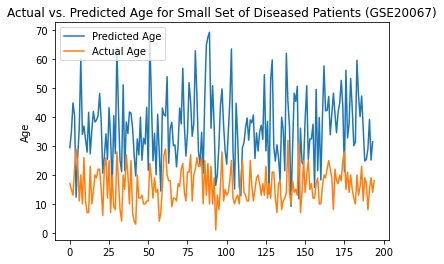

In [24]:
plt.plot(disease_predictions)
plt.plot(disease_Y)
plt.title("Actual vs. Predicted Age for Small Set of Diseased Patients (GSE20067)")
plt.ylabel('Age')
plt.legend(['Predicted Age', 'Actual Age'], loc='upper left')
plt.show()

## Conclusion
As can be seen above, the predicted age (shown in blue) is generally much higher than the actual age (orange) of the diseased individual. This matches the expected results, since the high levels of biological damage associated with chronic conditions has been associated with a methylation pattern reflecting individuals older than the person themself.
With this, we can conclude that the random forest regressor is quite accurate at predicting the biological age, and represents the correct trend with diseased individuals.